# Projectile motion

In [1]:
# Import some libraries from python and set some defaults
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import sys
import os
import time
sys.path.append(os.getcwd())
# from scipy.interpolate import CubicSpline
import pickle
import copy
plt.rcParams.update({'font.size': 17})
params = {'axes.labelsize': 16, 'axes.titlesize': 16}
plt.rcParams.update(params)
rc('animation', html='html5')

In [2]:
# get the base file
import requests
from pathlib import Path
if Path("DEq_Solver.py").is_file():
    print("DEq_Solver already exist")
else:
    print("Downloading the DEq_solver")
    request = requests.get("https://raw.githubusercontent.com/keithonpy/Scientific_Computing/main/Base/DEq_Solver.py")
    with open("DEq_Solver.py", "wb") as f:
        f.write(request.content)
print("Deq_Solver imported")
from DEq_Solver import DEq_Solver

DEq_Solver already exist
Deq_Solver imported


Implement the second and fourth order Runge-Kutta method in the cell below. You have access to 
- the current coordinates array as ``self.x``
- the current time as ``self.t``
- the derivative $dx/dt$ as ``self.kernel.dx_dt(self.x,self.t)``
- the timestep $\Delta t$ as ``self.delta_t``.

Note that both classes below are derived from the DEq_Solver class which is defined in DEq_Solver.py (same directory). They will thus feature all methods defined in DEq_Solver as well as the methods defined for the individual derived classes.


**2nd order Runge-Kutta method**

Remeber in Radioactive decay notebook, $dx/dt = f(x, t)$, the 2nd order Runge-Kuuta method improve the Euler's method:
$$
x' = x + f(x, t)\frac{\Delta t}{2} \\
x(t + \Delta t) = x(t) + f(x', t') \Delta t \\
x^{n+1} = x^{n} + f(x^{n} + \frac{\Delta t}{2} f(x^{n}, t^{n}), t^{n}+\frac{\Delta t}{2}) \Delta t
$$

**4th order Runge-Kutta method**
Further improvement of 2nd order Runge-Kutta method by taking more points
$$
x(t + \Delta t) = x(t) + \frac{\Delta t}{6} [f(x_{1}', t_{1}') + 2f(x_{2}',t_{2}')+ 2f(x_{3}', t_{3}')+f(x_{4}', t_{4}')]
$$

where
$$
x_{1}' = x \text{   &   } t_{1}' = t 
$$
$$
x_{2}' = x + f(x_{1}', t_{1}') \text{   &   } t_{2}' = t + \frac{\Delta t}{2} \\
$$
$$
x_{3}' = x + f(x_{2}', t_{2}') \text{   &   } t_{3}' = t + \frac{\Delta t}{2} \\
$$
$$
x_{4}' = x + f(x_{3}', t_{3}') \text{   &   } t_{4} = t + \Delta t
$$


In [16]:
class RK2Solver(DEq_Solver):
    def __init__(self,kernel):
        self.kernel  = kernel
    def makeStep(self):
        # implement the method for performing a step according to the second-order Runge-Kutta algorithm
        # You have access to
        # self.t: current time
        # self.delta_t: the timestep
        # self.x: state of the system at time t
        # self.kernel.dx_dt(x, t): the derivative, dx/dt, at time t
        # input: none
        # output: none
        # the routine should update x and t
        # YOUR CODE HERE
        # inner function
        x_pi = self.x + self.kernel.dx_dt(self.x, self.t)* self.delta_t / 2.0
        t_pi = self.t + self.delta_t / 2.0
        # outer function
        self.x += self.kernel.dx_dt(x_pi, t_pi)*self.delta_t 
        self.t += self.delta_t

class RK4Solver(DEq_Solver):
    def __init__(self,kernel):
        self.kernel  = kernel
    def makeStep(self):
        # implement the method for performing a step according to the fourth-order Runge-Kutta algorithm
        # You have access to
        # self.t: current time
        # self.delta_t: the timestep
        # self.x: state of the system at time t
        # self.kernel.dx_dt(x, t): the derivative, dx/dt, at time t
        # input: none
        # output: none
        # the routine should update x and t
        # YOUR CODE HERE
        x1 = self.x
        t1 = self.t
        x2 = self.x + self.kernel.dx_dt(x1, t1)*self.delta_t /2
        t2 = self.t + self.delta_t /2
        x3 = self.x + self.kernel.dx_dt(x2, t2)*self.delta_t/2
        t3 = self.t + self.delta_t /2
        x4 = self.x + self.kernel.dx_dt(x3, t3)*self.delta_t
        t4 = self.t + self.delta_t
        
        self.x += self.delta_t / 6 * (self.kernel.dx_dt(x1,t1)
                                      + 2*self.kernel.dx_dt(x2, t2) 
                                      + 2*self.kernel.dx_dt(x3, t3)
                                      + self.kernel.dx_dt(x4, t4))
        self.t += self.delta_t

In [4]:
class testKernel:
    def dx_dt(x,t):
        return 2.0*t+x

solver=RK2Solver(testKernel)
x0=np.array([0.0])
solver.initialise(x0,0,1,0.1)
for i in range(5):
    solver.makeStep()
assert np.isclose(solver.x[0],0.2948935)

In [5]:
class testKernel:
    def dx_dt(x,t):
        return 2.0*t+x[1]-3.0*x[0]

solver=RK4Solver(testKernel)
x0=np.array([1.0,0.2])
solver.initialise(x0,0,1,0.1)
for i in range(5):
    solver.makeStep()
assert np.isclose(solver.x,np.array([0.29898195, -0.50101805])).all()

In projectile motion, we often want to compute the projectile's range  -- that is the distance it travels horizontally before it hits the ground (assuming Earth is flat!). To do so, we interpolate the trajectory between the two final steps (one above, and one *below* ground level) to determine the range more accurately. The function in the cell below does so by implementing **linear interpolation**.

Interpolate the value of $f(x)$ given *left*=$(x0,y0)$ and *right*=$(x1,y1)$ anchor points (where *left* is the last step 
with $y>0$, and *right* is the first step where $y<0$. $y$ is of course the height above the ground.)


In [6]:
def interpolate(x,left,right):
    # Implement linear interpolation
    # input: left:    point with Cartesian coordinates (x0, y0) = left
    #        right:   point with Cartesian coordinates (x1, y1) = right
    #        x:       x-coordinate of a point
    # output: y
    #     such that the point with Cartesian coordinates (x, y) lies on the straight line
    #     that passes through the points (x0, y0) and (x1, y1)
    x0, y0 = left
    x1, y1 = right
    # YOUR CODE HERE
    
    slope = (y1-y0) / (x1-x0)
    intercept = (x1*y0 - x0*y1) / (x1-x0)
    return slope*x+intercept

Below cell tests the implementation of linear interpolation

In [7]:
left=(0.4,4.5)
right=(0.6,7.78)
assert np.isclose(interpolate(0.45,left,right),5.32)

A second order differential equation (here, describing the trajectory of a projectile) can be re-written as two coupled, first order equations. Since we have two, second-order DEs (one for horizontal motion, one for vertical motion), we will have 4 coupled first order equations for ballistic motion in two dimensions.

We implement this by using the array ``x = np.array([s,h,vs,vh])``, where ``s`` and ``vs`` are horizontal distance and horizontal velocity, and ``h`` and ``vh`` are height and vertical velocity, respectively.

We will use the linear interpolation function to determine the range of the projectile by interpolating the last two steps of the solver to height $h = 0$.

Implement the kernel ``dx_dt`` in the class below and also complete the method for drag force (a.k.a. air resistance) as a function of velocity ${\bf v}$, 

${\bf F}_{\rm drag}(h) = -B_{2,\rm drag}(h)\,v^2\frac{\bf v}{v}$

Here ${\bf v}$ is the velocity, with Cartesian components $(vs,vh)$, and $v$ is the *speed* (magnitude of ${\bf v}$),
$v=\left(vs^2+vh^2\right)^{1/2}$.

Implement 3 different air models for the drag coefficient as a function of height, $h$:

 - constant: $B_{2,  \rm drag}=1$
 
 - isothermal: $B_{2,\rm drag}(h)=\exp(-h/10^4{\rm m})$
 
 - adiabatic: 
     - $B_{2,\rm drag}(h)=0$ for $h> (300./0.0065){\rm m}$
     
     - $B_{2,\rm drag}(h) = (1-0.0065*h/ (300{\rm m}))^{2.5}$ for $h\le (300./0.0065){\rm m}$
             
Assume the projectile's mass, is $m=1$ kg. In this expression, the factors 300 and 0.0065 apply to motion in the Earth's atmosphere.


**Numerical solution:**


$$
x^{n+1} = x^{n}+ v_{x}^{n} \Delta t; \; \; \;
v_{x}^{n+1} = v_{x}^{n} - \frac{\textbf{B}(y^{n})v^{n}v_{x}^{n}}{m} \Delta t
$$

$$
y^{n+1} = y^{n} + v_{y}^{n} \Delta t; \; \; \;
v_{y}^{n+1} = v_{y}^{n} - g\Delta t - \frac{\textbf{B}(y^{n})v^{n}v_{y}^{n}}{m} \Delta t
$$

$$
t^{n+1} = t^{n} + \Delta t \\
v^{n} = ((v_{x}^{n})^{2} + (v_{y}^{n})^{2})^{1/2}
$$


In [40]:
class Cannonball:
    def __init__(self,B_m,airmodel='const'):
        """Initialize a cannonball object with drag coefficient B/m
        and an optional air density model"""
        self.B_m = float(B_m)
        self.airmodel = airmodel
        
    def correctionFactor(self,height):
        # Implement the calculation of the drag coefficient, B_(2, drag)
        #   as a function of height
        # input: the height, h, in meters
        # returns: B_(2, drag)
        # As an example: constant airmodel
        if self.airmodel == 'const':  
            return 1.0
        elif self.airmodel == 'isothermal': 
        # YOUR CODE HERE
            return np.exp(-height/10**4)
        elif self.airmodel == 'adiabatic':  
        # YOUR CODE HERE
            return 0 if height > (300 /0.0065) else (1-0.0065*height / 300) ** 2.5
        else:
            raise Exception('Unknown air model',self.airmodel)

    def dx_dt(self,x,t):
        # implement the rate of change, dx/dt, including gravity and drag
        # input: t: current time
        #        x: the location of the cannon ball at time t
        #          where x[0] is the horizontal position
        #                x[1] is the vertical position (height)
        #                x[2] is the horizontal velocity
        #                x[3] is the vertical velocity
        # return: dx/dt
        # YOUR CODE HERE
        _, y, vx, vy = x
        B =  self.correctionFactor(y)
        
        v = (vx**2.0 + vy**2.0)**(1/2)
        g = 9.81 # gravity
        
       
        
        dx = vx
        dy = vy
        
        dvx = - B*v*vx * self.B_m
        dvy = - g - B*v*vy * self.B_m
       
        return np.array([dx, dy, dvx, dvy])



def cannon_range(solver):
    # Calculate the range of the shot, by interpolating
    # between the last two points in the solver history for which
    # the penultimate step has height h>0, and the last step has h<0.
    # Use linear interpolation to compute the range, i.e. where h=0
    # input:   the solver
    # returns: the value of the horizontal position along the trajectory where the height, h=0
    # Solution:
    # extract the (x,y) coordinates of all the steps from the solver
    xs, ys, _, _ = solver.coordinateSteps()

    # now interpolate linearly between the last two
    # YOUR CODE HERE
#     left = (xs[-2], ys[-2])
#     right = (xs[-1], ys[-1])
    
#     for x in range(xs[-2], xs[-1], 0.01):
#         if interpolate(x, left, right) <= 1e-10:
#             return x
    x0 = xs[-1]
    x1 = xs[-2]
    y0 = ys[-1]
    y1 = ys[-2]
    h=0
    return ((h-y0)*(x1-x0)/(y1-y0) + x0)
    

The cell below tests the ballistic motion implementation

In [41]:
test_const=Cannonball(4.5e-2,airmodel='const')
test_iso=Cannonball(4.5e-2,airmodel='isothermal')
test_adia=Cannonball(4.5e-2,airmodel='adiabatic')
x=np.array([0.0,3.4,0.1,0.7])
test_const.dx_dt(x,0.1)
assert np.isclose(test_const.dx_dt(x,0.1),np.array([  0.1, 0.7, -3.18198052e-03,
        -9.83227386e+00])).all()

assert test_const.correctionFactor(0.9)==1
assert np.isclose(test_iso.correctionFactor(912),0.912835,1e-4)
assert np.isclose(test_adia.correctionFactor(912),0.9513297,1e-4)

The cell below can be used to visualize the trajectory of the projectile, for different choices of
how the air density depends on height $h$.


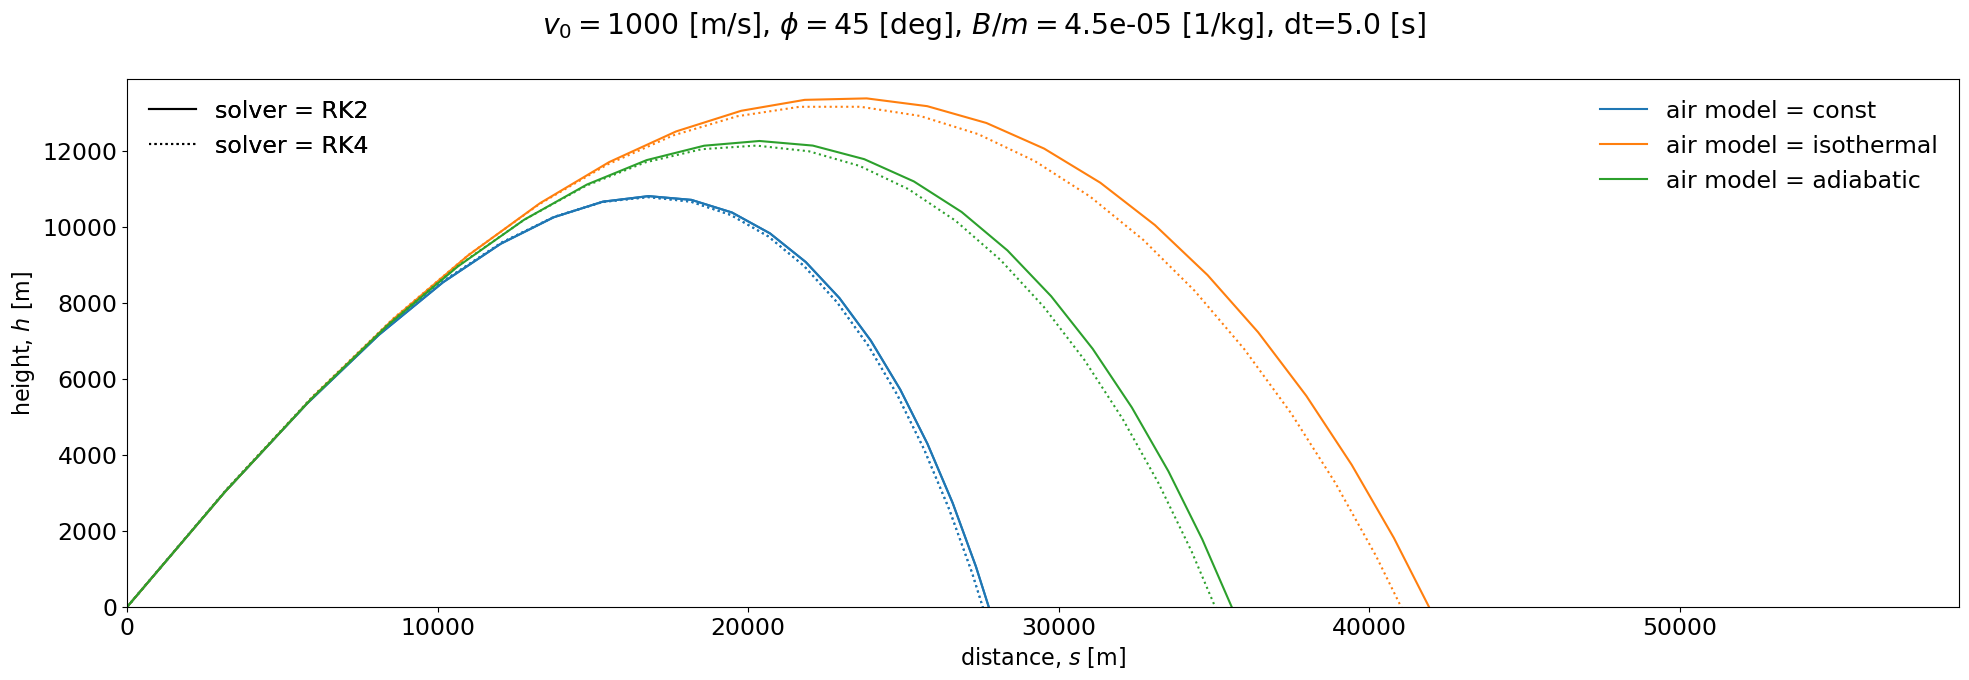

In [43]:
# Notice in particular how the legend is built-up:
#   colours indicate models for the atmosphere (i.e model of how B depends on height)
#   line styles indicate different integration methods (e.g. RK2, RK4)
v0       = 1000    # Launch speed (m/s)
phi_deg  = 45      # Launch angle (deg)
t0       = 0       # Launch time (s)
t1       = 200.    # Maximum duration of the integration(should be larger than flight time) (s)
delta_t  = 5.0     # Time-step of integrator (s)
B_m      = 4.5e-5  # Drag coeffecient divided by projectile's mass, B/m (1/kg)

# convert angle from degrees to radians (why do this?)
phi      = phi_deg * np.pi / 180.

# generate initial state vector
x0 = np.array([0, 0, v0*np.cos(phi), v0*np.sin(phi)])

# prepare plot and annotate with initial parameters
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
fig.suptitle('$v_0=$%s [m/s], $\phi=$%s [deg], $B/m=$%s [1/kg], dt=%s [s]'
            %(
                v0,
                phi_deg,
                B_m,
                delta_t))
    
# plot horizontal distance, s, versus height, h
ax.set_ylabel(r'height, $h$ [m]')
ax.set_xlabel(r'distance, $s$ [m]')
    
def negativeY(x):
    return x[1] < 0


maxy=0

# set the models to plot, and generate a separate colour for each of them
airmodels = ['const','isothermal','adiabatic']
nplot    = len(airmodels)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.CMRmap(np.linspace(0., 1., nplot+1))))
cycle    = plt.rcParams['axes.prop_cycle'].by_key()['color']
nsys     = np.arange(nplot)

# use different line styles to indicate different integration methods
methods    = [(RK2Solver,'RK2'), (RK4Solver,'RK4')]
linestyles = ['solid', 'dotted']
nmethods   = np.arange(len(methods))

# Note how we create the different handles to creat the legend
handles  = []
handles2 = []
for (isys, airmodel) in zip(nsys, airmodels):
    color  = cycle[isys]
    cannon = Cannonball(B_m,airmodel)
    alabel = r"air model = {}".format(airmodel)   # label to distinguish different air models
    for (imed, linestyle, method) in zip(nmethods, linestyles, methods):
        solverType = method[0]
        name       = method[1]
        mlabel     = r"solver = {}".format(name)  # label to distinguish solvers
        solver     = solverType(cannon)
        result     = solver.solve(x0,t0,t1,delta_t,terminateCondition=negativeY)
        xs,ys,_,_ = solver.coordinateSteps()
        # plot result for this solver and this air model
        if (imed == 0):
            h, = ax.plot(xs, ys, color=color, linestyle=linestyle, label=alabel)
            handles.append(copy.copy(h))
        else:
            ax.plot(xs, ys, color=color, linestyle=linestyle)
        if (isys == 0):
            h, = ax.plot(xs, ys, color=color, linestyle=linestyle, label=mlabel)
            handles2.append(copy.copy(h))
                
ax.set_xlim([0, 59000])
ax.set_ylim([0, 13900])
ax.legend() 

# make legend for airmodels
first_legend = ax.legend(handles=handles, loc='upper right', frameon=False)
ax.add_artist(first_legend)

# make legend for integrators. Set color to black to avoid confusion
for h in handles2:
    h.set_color("black")      
second_legend = ax.legend(handles=handles2, loc='upper left', frameon=False)
ax.add_artist(second_legend)
fig.tight_layout()



Here is an example of how a figure caption could look like.

Trajectories for a projectile with mass $m=1{\rm kg}$, launched with speed $v_0=1000~{\rm m~s}^{-1}$ under an angle of 
$\phi=45^\circ$, computed numerically. The *solid* line and *dotted* line show the results when using the RK2 or RK4 integrators, respectively. *Colours* show different models for the drag coefficient $B$: *blue* has constant $B$, 
*yellow* uses the isothermal model, *green* uses the adiabatic model. The integration timestep is $dt=0.5~{\rm s}$.



**Bisection method to find answer**

Use the adiabatic air model with a value of B/m = 2e-5, and a launch angle of 25 degrees, compute the launch speed,  𝑣0
 , that yields a range of 33256.0 m. Give your answer accurate to 6 significant digits.

In [61]:
x = 33256
phi_deg = 25
B_m = 2e-5
t0       = 0       
t1       = 400.    
delta_t  = 5.0 
phi      = phi_deg * np.pi / 180.

a, b = 0, 1000
ranges_c = 0

while abs(ranges_c - x) >=1e-8:
    # calculate f(a)
    x0 = np.array([0, 0, a*np.cos(phi), a*np.sin(phi)])
    cannon = Cannonball(B_m,'adiabatic')
    solver = RK2Solver(cannon)
    solver.solve(x0,t0,t1,delta_t,terminateCondition=negativeY)
    ranges_a = cannon_range(solver)
    
    # calculate f(b)
    x0 = np.array([0, 0, b*np.cos(phi), b*np.sin(phi)])
    cannon = Cannonball(B_m,'adiabatic')
    solver = RK2Solver(cannon)
    solver.solve(x0,t0,t1,delta_t,terminateCondition=negativeY)
    ranges_b = cannon_range(solver)
    
    
    c = (a + b) / 2
    # calculate f(c)
    x0 = np.array([0, 0, c*np.cos(phi), c*np.sin(phi)])
    cannon = Cannonball(B_m,'adiabatic')
    solver = RK2Solver(cannon)
    solver.solve(x0,t0,t1,delta_t,terminateCondition=negativeY)
    ranges_c = cannon_range(solver)
    
    if ranges_c > x:
        b = c
    else:
        a = c
        
print(f"The required speed to have a range of {x} is {c} ms^(-1)")
    

33256.00000000224
The required speed to have a range of 33256 is 813.6988226024187 ms^(-1)


In [ ]:
813.4061957010999 